In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [326]:
import sys
import itertools
from os.path import join as pjoin
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

# Parameters

In [364]:
N_ENSEMBLES = 20
DENSITY_FILE = "../../data/Derived/Publication_based/Transition/density_and_timeflag_full_1973-2017.csv"
INCOME_GROUP_FILE = "../../data/Derived/Country_metadata/cntry_year_incomegroup.csv"

# The parameters from the bootsrapped samples will be used for further simulations. 
DENSITY2PROB_PARAMS = "../../data/Derived/Publication_based/Transition/density2prob_full_1973-2017.csv"

# The four-panel figure. 
FIGURE_PATH = "../../Figs/transition/full/transition_incomegroup_all.pdf"

# Preparing the dataset

In [22]:
density_df = pd.read_csv(DENSITY_FILE)
density_df.head()

,DIS,Density,st0,st1,COUNTRY,CRRT_TIME
0,Acoustics,0.129612,0,0,Afghanistan,1973-1977
1,Addictive Diseases,0.171459,1,0,Afghanistan,1973-1977
2,Aerospace Technology,0.131653,0,0,Afghanistan,1973-1977
3,Agricult & Food Science,0.215552,1,1,Afghanistan,1973-1977
4,Allergy,0.188202,0,0,Afghanistan,1973-1977


In [23]:
income_group_df = pd.read_csv(
    INCOME_GROUP_FILE, sep=",", names=["INCOMEGROUP", "YEAR", "COUNTRY"]
)
income_group_df.head()

,INCOMEGROUP,YEAR,COUNTRY
Code,IncomeGroup,YEAR,WoS
AFG,L,1988-1992,Afghanistan
AFG,L,1993-1997,Afghanistan
AFG,L,1998-2002,Afghanistan
AFG,L,2003-2007,Afghanistan


In [24]:
density_df = density_df.merge(
    income_group_df,
    left_on=["COUNTRY", "CRRT_TIME"],
    right_on=["COUNTRY", "YEAR"],
    how="left",
)
density_df.head()

,DIS,Density,st0,st1,COUNTRY,CRRT_TIME,INCOMEGROUP,YEAR
0,Acoustics,0.129612,0,0,Afghanistan,1973-1977,NaN,NaN
1,Addictive Diseases,0.171459,1,0,Afghanistan,1973-1977,NaN,NaN
2,Aerospace Technology,0.131653,0,0,Afghanistan,1973-1977,NaN,NaN
3,Agricult & Food Science,0.215552,1,1,Afghanistan,1973-1977,NaN,NaN
4,Allergy,0.188202,0,0,Afghanistan,1973-1977,NaN,NaN


In [25]:
bins = np.arange(0, 1.05, 0.05)
labels = np.arange(0.05, 1.05, 0.05)
density_df["binned"] = pd.cut(
    density_df["Density"], bins, labels=labels, include_lowest=True
)
density_df = density_df[density_df.DIS != "Unknown"]
density_df.head()

,DIS,Density,st0,st1,COUNTRY,CRRT_TIME,INCOMEGROUP,YEAR,binned
0,Acoustics,0.129612,0,0,Afghanistan,1973-1977,NaN,NaN,0.15
1,Addictive Diseases,0.171459,1,0,Afghanistan,1973-1977,NaN,NaN,0.20
2,Aerospace Technology,0.131653,0,0,Afghanistan,1973-1977,NaN,NaN,0.15
3,Agricult & Food Science,0.215552,1,1,Afghanistan,1973-1977,NaN,NaN,0.25
4,Allergy,0.188202,0,0,Afghanistan,1973-1977,NaN,NaN,0.20


# Resampling 

For each income group, we extract the data and run the bootstrap sampling to estimate the error.

In [223]:
def resample_transition(df, incomegroup="ALL", from_st=0, threshold_cnt=20):
    if incomegroup != "ALL":
        df = df.query(f"INCOMEGROUP == '{incomegroup}'")
    cnt_df = df.loc[:, ["st0", "st1", "binned"]].sample(
        len(df), replace=True
    ).query(f"st0 == {from_st}").groupby(
        ["binned", "st1"]
    ).size().reset_index(name="count").pivot(index="binned", columns="st1", values="count")
    cnt_df = cnt_df[cnt_df[0] + cnt_df[1] > threshold_cnt]
    return cnt_df.div(cnt_df.sum(axis=1), axis=0).dropna()  # if fillna(0) is used, then it will throw out data points. 

For instance, 

In [226]:
cnt_from_sample = density_df.query("INCOMEGROUP == 'H'").loc[:, ["st0", "st1", "binned"]].sample(
    len(density_df), replace=True
).query("st0 == 0").groupby(
    ["binned", "st1"]
).size().reset_index(name="count")
cnt_from_sample.head()

,binned,st1,count
0,0.05,0,5426
1,0.05,1,161
2,0.10,0,7897
3,0.10,1,410
4,0.15,0,10063


In [196]:
temp_df = cnt_from_sample.pivot(index="binned", columns="st1", values="count")
temp_df[temp_df[0] + temp_df[1] > 20]

st1,0,1
binned,,
0.05,5450,161
0.1,7950,404
0.15000000000000002,9881,980
0.2,8993,782
0.25,12370,1070
0.3,16166,2089
0.35000000000000003,19531,2960
0.4,17353,2749
0.45,13336,2263


In [112]:
xdf = temp_df.div(temp_df.sum(axis=1), axis=0).dropna()
xdf

st1,0,1
binned,,
0.05,0.975381,0.024619
0.1,0.949339,0.050661
0.15000000000000002,0.908003,0.091997
0.2,0.924124,0.075876
0.25,0.914876,0.085124
0.3,0.890871,0.109129
0.35000000000000003,0.875229,0.124771
0.4,0.866471,0.133529
0.45,0.860074,0.139926


In [120]:
list(xdf.index)

[0.05,
 0.1,
 0.15000000000000002,
 0.2,
 0.25,
 0.3,
 0.35000000000000003,
 0.4,
 0.45,
 0.5,
 0.55,
 0.6000000000000001,
 0.6500000000000001,
 0.7000000000000001,
 0.7500000000000001,
 0.8]

In [118]:
list(xdf[1])

[0.024619199433227063,
 0.050660525996848865,
 0.09199673706154264,
 0.07587568859785886,
 0.08512360211889347,
 0.1091290097254312,
 0.1247708882828915,
 0.13352923597967925,
 0.13992561241503143,
 0.15233259282767375,
 0.21658892719529507,
 0.24560168895144266,
 0.22063492063492063,
 0.22771213748657357,
 0.2953846153846154,
 0.5205479452054794]

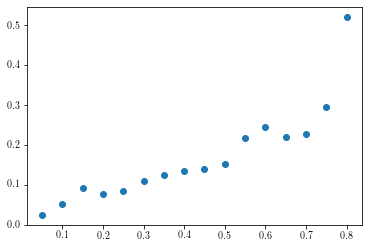

In [117]:
plt.scatter(np.array(xdf.index), np.array(xdf[1]))

Now we can compute the data for each income group and starting state. 

# Data generation for plotting

In [353]:
income_group = ["L", "LM", "UM", "H"]
starting_states = [0, 1] # 0: DISADV, 1: ADV

from itertools import product
from collections import defaultdict

def ols_beta(df, end_state):
    sm_df = df.rename(columns={end_state: "TARGET"}).reset_index()
    sm_df['x'] = sm_df.binned.astype('float')
    result = smf.ols("TARGET ~ x", data=sm_df).fit()
    return (result.params[0], result.params[1])

plot_data = {}
    
for igroup, st_state in product(income_group + ["ALL"], starting_states):
    end_state = 0 if st_state else 1
    print(igroup, st_state, end_state)
    
    plot_data[(igroup, st_state)] = {'x': [], 'y': [], 'beta': [], 'beta0': []}
    
    for i in range(N_ENSEMBLES):
        df = resample_transition(density_df, incomegroup=igroup, from_st=st_state)
        plot_data[(igroup, st_state)]['x'].append(np.array(df.index))
        plot_data[(igroup, st_state)]['y'].append(np.array(df[end_state]))
        
        beta0, beta = ols_beta(df, end_state=end_state)
        plot_data[(igroup, st_state)]['beta0'].append(beta0)
        plot_data[(igroup, st_state)]['beta'].append(beta)

L 0 1
L 1 0
LM 0 1
LM 1 0
UM 0 1
UM 1 0
H 0 1
H 1 0
ALL 0 1
ALL 1 0


Explanation of the `ols_beta()` for calculating the linear trend

In [354]:
df = resample_transition(density_df, incomegroup="ALL", from_st=1)
df.head()

st1,0,1
binned,,
0.05,0.710317,0.289683
0.1,0.649123,0.350877
0.15000000000000002,0.575281,0.424719
0.2,0.526044,0.473956
0.25,0.443210,0.556790


In [355]:
sm_df = df.rename(columns={0: "TARGET"}).reset_index()
sm_df.head()

st1,binned,TARGET,1
0,0.05,0.710317,0.289683
1,0.10,0.649123,0.350877
2,0.15,0.575281,0.424719
3,0.20,0.526044,0.473956
4,0.25,0.443210,0.556790


In [356]:
sm_df['x'] = sm_df.binned.astype('float')
sm_df

st1,binned,TARGET,1,x
0,0.05,0.710317,0.289683,0.05
1,0.10,0.649123,0.350877,0.10
2,0.15,0.575281,0.424719,0.15
3,0.20,0.526044,0.473956,0.20
4,0.25,0.443210,0.556790,0.25
5,0.30,0.365955,0.634045,0.30
6,0.35,0.284755,0.715245,0.35
7,0.40,0.235294,0.764706,0.40
8,0.45,0.174852,0.825148,0.45
9,0.50,0.135492,0.864508,0.50


In [357]:
result = smf.ols("TARGET ~ x", data=sm_df).fit()
result.params[1]

-0.9191535771626032

# Saving the mean coefficients for the null model

In [362]:
pd.DataFrame(
    (igroup, st_state, np.mean(curr_data['beta0']), np.mean(curr_data['beta'])) 
        for (igroup, st_state), curr_data in plot_data.items()
).rename(
    columns={0: "INCOME_GROUP", 1: "START_STATE", 2: "CONSTANT", 3: "SLOPE"}
).to_csv(DENSITY2PROB_PARAMS, index=False)
    

INCOME_GROUP,START_STATE,CONSTANT,SLOPE
L,0,-0.054241711989907605,0.8119565233702346
L,1,0.8083327720447864,-1.3002899430009442
LM,0,-0.07047504895812437,0.8787939880046813
LM,1,0.7697266488827124,-1.2447450056660323
UM,0,-0.04021572956814151,0.6677700463250473
UM,1,0.6959586838909463,-1.0687880277412247
H,0,0.011539743108678552,0.3394129812186287
H,1,0.6585742623798072,-0.9197543646651104
ALL,0,0.036329622182343986,0.3240198156202262
ALL,1,0.6726001819070231,-0.9229592064355977



# Plotting parameters and functions

In [359]:
colormap = {"L": "#1B65A6", "LM": "#9BDAF2", "UM": "#FFAF4D", "H": "#E05E00", "ALL": "#008F00"}
scatter_size = 0.2
linewidth = 0.5

def plot_transition(ax, data, igroups=["ALL"], st_state=0):
    ylabel = {0: "Activation probability", 1: "Deactivation probability"}
    ax.set_xlim((0.0, 0.82))
    ax.set_ylim((0.0, 1.02))
    ax.set_ylabel(ylabel[st_state], fontsize=14)

    for igroup in igroups:
        ind_data = data[(igroup, st_state)]
        x_all = list(itertools.chain(*ind_data['x']))
        y_all = list(itertools.chain(*ind_data['y']))
        beta_mean, beta_std = np.mean(ind_data['beta']), np.std(ind_data['beta'])
        for sample_idx in range(N_ENSEMBLES):
            ax.scatter(x=add_jitter(ind_data['x'][sample_idx], 0.025),y=ind_data['y'][sample_idx], 
                       s=scatter_size, c=colormap[igroup])
        sns.regplot(x=x_all, y=y_all, scatter=False, ci=99, ax=ax, color=colormap[igroup], 
                    line_kws={"linewidth": linewidth}, 
                    label=f"{igroup}, Slope: {beta_mean:.2f} ({beta_std:.2f})")        
    return fig, ax

def add_jitter(data, jitter_width=1.0):
    return data + (np.random.sample(size=len(data)) - 0.5) * jitter_width

# The plot

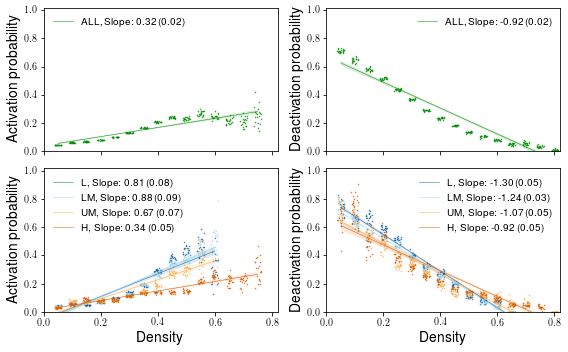

In [360]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(8,5))

plot_transition(ax=axs[0][0], data=plot_data, igroups=["ALL"], st_state=0)
plot_transition(ax=axs[0][1], data=plot_data, igroups=["ALL"], st_state=1)
plot_transition(ax=axs[1][0], data=plot_data, igroups=income_group, st_state=0)
plot_transition(ax=axs[1][1], data=plot_data, igroups=income_group, st_state=1)

axs[1][0].set_xlabel("Density", fontsize=14)
axs[1][1].set_xlabel("Density", fontsize=14)

axs[0][0].legend(loc="upper left", frameon=False)
axs[0][1].legend(loc="upper right", frameon=False)
axs[1][0].legend(loc="upper left", frameon=False)
axs[1][1].legend(loc="upper right", frameon=False)


fig.tight_layout()
fig.savefig(FIGURE_PATH)